# Initiating Spark

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Data Clustering").getOrCreate()

In [3]:
print (spark)

# Loading Dataset

In [4]:
df = spark.read.csv("D:/KULIAH/SMT-6_BIG DATA/building-violations.csv", header=True, inferSchema=True)

In [5]:
df.count()

1600373

In [6]:
df.head()

Row(ID=1001846, VIOLATION LAST MODIFIED DATE=datetime.datetime(2008, 5, 20, 11, 55, 49), VIOLATION DATE=datetime.datetime(2007, 3, 15, 0, 0), VIOLATION CODE='EV0065', VIOLATION STATUS='COMPLIED', VIOLATION STATUS DATE=datetime.datetime(2008, 4, 28, 0, 0), VIOLATION DESCRIPTION='TEST G & S PASS ELE', VIOLATION LOCATION='BOTH CARS', VIOLATION INSPECTOR COMMENTS='FULL LOAD', VIOLATION ORDINANCE='Test governor and car safety and submit copy of test results to Elevator Bureau for passenger elevator. (13-156-820, 13-20-120)', INSPECTOR ID='541666', INSPECTION NUMBER='2089609', INSPECTION STATUS='PASSED', INSPECTION WAIVED='N', INSPECTION CATEGORY='PERIODIC', DEPARTMENT BUREAU='ELEVATOR', ADDRESS='330 N JEFFERSON ST', STREET NUMBER='330', STREET DIRECTION='N', STREET NAME='JEFFERSON', STREET TYPE='ST', PROPERTY GROUP='1901', SSA=None, LATITUDE='41.887764416', LONGITUDE='-87.64297689', LOCATION='"{\'latitude\': \'41.887764415875786\', \'needs_recoding\': False, \'human_address\': \'{""address"

In [7]:
df.schema

StructType(List(StructField(ID,IntegerType,true),StructField(VIOLATION LAST MODIFIED DATE,TimestampType,true),StructField(VIOLATION DATE,TimestampType,true),StructField(VIOLATION CODE,StringType,true),StructField(VIOLATION STATUS,StringType,true),StructField(VIOLATION STATUS DATE,TimestampType,true),StructField(VIOLATION DESCRIPTION,StringType,true),StructField(VIOLATION LOCATION,StringType,true),StructField(VIOLATION INSPECTOR COMMENTS,StringType,true),StructField(VIOLATION ORDINANCE,StringType,true),StructField(INSPECTOR ID,StringType,true),StructField(INSPECTION NUMBER,StringType,true),StructField(INSPECTION STATUS,StringType,true),StructField(INSPECTION WAIVED,StringType,true),StructField(INSPECTION CATEGORY,StringType,true),StructField(DEPARTMENT BUREAU,StringType,true),StructField(ADDRESS,StringType,true),StructField(STREET NUMBER,StringType,true),StructField(STREET DIRECTION,StringType,true),StructField(STREET NAME,StringType,true),StructField(STREET TYPE,StringType,true),Struct

In [8]:
df.createOrReplaceTempView("violations")

# Training 

### 1. Retrieving Data

In [28]:
#daftar pelanggaran yang banyak terjadi
Query1 = spark.sql("SELECT `VIOLATION DESCRIPTION` AS VIOLATION, COUNT(`VIOLATION DESCRIPTION`) AS TOTAL \
                    FROM violations \
                    GROUP BY `VIOLATION DESCRIPTION`\
                    ORDER BY COUNT(`VIOLATION DESCRIPTION`) DESC")

In [29]:
Query1.show()

+--------------------+-----+
|           VIOLATION|TOTAL|
+--------------------+-----+
|ARRANGE PREMISE I...|85066|
|POST OWNER/MANAGE...|56292|
|REPAIR EXTERIOR WALL|49096|
| REPAIR PORCH SYSTEM|41841|
|MAINTAIN OR REPAI...|39671|
|VACANT BUILDING -...|35147|
|REPLCE WINDOW PAN...|33242|
|REPAIR EXTERIOR S...|30686|
|INSTALL SMOKE DET...|29651|
|PLANS & PERMITS R...|27088|
|FILE BLDG REGISTR...|26617|
|STOP/REMOVE NUISANCE|24375|
|MAINTAIN OR REPAI...|23732|
|CARB MONOX DETECT...|22542|
|   DEBRIS, EXCESSIVE|22375|
|REPAIR EXTERIOR DOOR|19160|
|OBSTRUCTIONS IN E...|19079|
|REPAIR INTERIOR W...|18518|
|             PARAPET|18059|
|REPAIR/REBUILD GA...|16796|
+--------------------+-----+
only showing top 20 rows



In [30]:
Query1.count()

1303

### 2. Assembling Vector

In [31]:
#import vector lib
from pyspark.ml.feature import VectorAssembler

In [40]:
#Convert Query1 into Vector
assembler = VectorAssembler(
    inputCols=["TOTAL"],
    outputCol='features')

violationType = assembler.transform(Query1)
violationType.show()

+--------------------+-----+---------+
|           VIOLATION|TOTAL| features|
+--------------------+-----+---------+
|ARRANGE PREMISE I...|85066|[85066.0]|
|POST OWNER/MANAGE...|56292|[56292.0]|
|REPAIR EXTERIOR WALL|49096|[49096.0]|
| REPAIR PORCH SYSTEM|41841|[41841.0]|
|MAINTAIN OR REPAI...|39671|[39671.0]|
|VACANT BUILDING -...|35147|[35147.0]|
|REPLCE WINDOW PAN...|33242|[33242.0]|
|REPAIR EXTERIOR S...|30686|[30686.0]|
|INSTALL SMOKE DET...|29651|[29651.0]|
|PLANS & PERMITS R...|27088|[27088.0]|
|FILE BLDG REGISTR...|26617|[26617.0]|
|STOP/REMOVE NUISANCE|24375|[24375.0]|
|MAINTAIN OR REPAI...|23732|[23732.0]|
|CARB MONOX DETECT...|22542|[22542.0]|
|   DEBRIS, EXCESSIVE|22375|[22375.0]|
|REPAIR EXTERIOR DOOR|19160|[19160.0]|
|OBSTRUCTIONS IN E...|19079|[19079.0]|
|REPAIR INTERIOR W...|18518|[18518.0]|
|             PARAPET|18059|[18059.0]|
|REPAIR/REBUILD GA...|16796|[16796.0]|
+--------------------+-----+---------+
only showing top 20 rows



### 3. Training Model

In [41]:
#import lib kmeans and clustering evaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [42]:
kmeans = KMeans().setK(5).setSeed(1)
model1 = kmeans.fit(violationType)

### 4. Make Prediction

In [44]:
#make prediction from data violation type
predictions1 = model1.transform(violationType)
predictions1.show()

+--------------------+-----+---------+----------+
|           VIOLATION|TOTAL| features|prediction|
+--------------------+-----+---------+----------+
|ARRANGE PREMISE I...|85066|[85066.0]|         1|
|POST OWNER/MANAGE...|56292|[56292.0]|         1|
|REPAIR EXTERIOR WALL|49096|[49096.0]|         1|
| REPAIR PORCH SYSTEM|41841|[41841.0]|         3|
|MAINTAIN OR REPAI...|39671|[39671.0]|         3|
|VACANT BUILDING -...|35147|[35147.0]|         3|
|REPLCE WINDOW PAN...|33242|[33242.0]|         3|
|REPAIR EXTERIOR S...|30686|[30686.0]|         3|
|INSTALL SMOKE DET...|29651|[29651.0]|         3|
|PLANS & PERMITS R...|27088|[27088.0]|         3|
|FILE BLDG REGISTR...|26617|[26617.0]|         3|
|STOP/REMOVE NUISANCE|24375|[24375.0]|         3|
|MAINTAIN OR REPAI...|23732|[23732.0]|         3|
|CARB MONOX DETECT...|22542|[22542.0]|         4|
|   DEBRIS, EXCESSIVE|22375|[22375.0]|         4|
|REPAIR EXTERIOR DOOR|19160|[19160.0]|         4|
|OBSTRUCTIONS IN E...|19079|[19079.0]|         4|


### 5. Evaluate

In [46]:
#Make variable for evaluting prediction data
evaluator = ClusteringEvaluator()

In [49]:
#Evaluate data violation type
silhouette1 = evaluator.evaluate(predictions1)
print("Silhouette with squared euclidean distance = " + str(silhouette1))

Silhouette with squared euclidean distance = 0.9610269373558445


# Vizualization

In [50]:
#import visual lib
import pixiedust

Pixiedust database opened successfully
Table VERSION_TRACKER created successfully
Table METRICS_TRACKER created successfully

Share anonymous install statistics? (opt-out instructions)

PixieDust will record metadata on its environment the next time the package is installed or updated. The data is anonymized and aggregated to help plan for future releases, and records only the following values:

{
   "data_sent": currentDate,
   "runtime": "python",
   "application_version": currentPixiedustVersion,
   "space_id": nonIdentifyingUniqueId,
   "config": {
       "repository_id": "https://github.com/ibm-watson-data-lab/pixiedust",
       "target_runtimes": ["Data Science Experience"],
       "event_id": "web",
       "event_organizer": "dev-journeys"
   }
}
You can opt out by calling pixiedust.optOut() in a new cell.


Pixiedust runtime updated. Please restart kernel
Table SPARK_PACKAGES created successfully
Table USER_PREFERENCES created successfully
Table service_connections created successfully



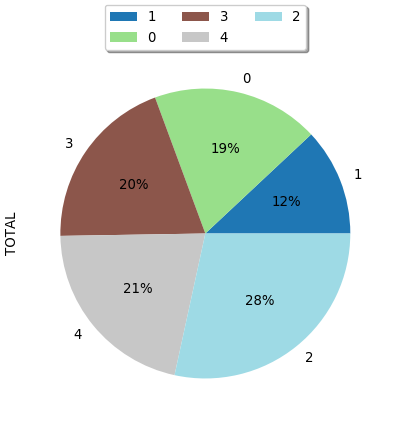

In [73]:
display(predictions1)